In [1]:
"""Library"""
import matplotlib.pyplot as plt
import pandas as pd
from common import (alpha_beta, data_path, date_col, fama_sharpe, missing_code,
                    price_col, processed_path, projectpath, symbol_col,
                    train_index, valid_index)

# load data
select = "factor"
data = pd.read_csv(data_path[select])
data[date_col] = pd.to_datetime(data[date_col])
data = data.set_index([symbol_col, date_col])\
    .replace(missing_code, float("NaN"))\
    .astype("float")

# keep only fama french factors
factor_cols = ["hml", "rmrf", "smb", "umd"]
data = data[[price_col] + factor_cols]

data.dropna().head()

excess_returns       hml      rmrf       smb       umd
symbol date                                                              
3IN    2008-04-30        0.024058  0.009833  0.058589 -0.049409  0.068718
       2008-05-31        0.008577 -0.029344 -0.006106 -0.010052  0.044772
       2008-06-30       -0.014719 -0.027738 -0.074837 -0.024877  0.135133
       2008-07-31       -0.006258 -0.069655 -0.040168  0.016760  0.001473
       2008-08-31       -0.079115 -0.001523  0.045881 -0.006549 -0.095469

In [2]:
"""Alpha Beta"""
coef = alpha_beta(data)

coef

,hml,rmrf,smb,umd,train_intercept,valid_intercept,test_intercept
3IN,0.276718,0.107114,-0.027427,-0.009705,0.002243,0.007851,0.007851
888,-0.268890,0.441525,0.045862,0.230667,0.001713,0.005537,0.005537
88E,5.940559,-5.522654,-7.530234,2.069211,-0.013257,0.030447,0.030447
AAIF,0.369862,-0.124749,-0.143021,-0.061102,0.008865,-0.003880,-0.003880
AAL,0.102185,0.047630,0.144582,-0.308291,0.011298,-0.013959,-0.013959
...,...,...,...,...,...,...,...
ZIOC,1.856091,-0.454311,1.755149,0.258530,-0.098083,0.161936,0.161936
ZOL,6.165694,-0.521288,-0.586116,1.347090,0.027960,-0.062722,-0.062722
ZOO,-1.255965,0.135807,0.522262,-0.621986,-0.014366,0.020553,0.020553
ZTF,0.226500,0.291467,0.352728,0.034285,-0.006456,0.021296,0.021296


In [3]:
coef["train_intercept"].abs().describe()

count    826.000000
mean       0.014558
std        0.018473
min        0.000003
25%        0.003436
50%        0.008406
75%        0.017942
max        0.179724
Name: train_intercept, dtype: float64

In [4]:
coef["valid_intercept"].abs().describe()

count    826.000000
mean       0.021833
std        0.025101
min        0.000060
25%        0.007099
50%        0.013880
75%        0.026454
max        0.187126
Name: valid_intercept, dtype: float64

In [5]:
coef["test_intercept"].abs().describe()

count    826.000000
mean       0.021833
std        0.025101
min        0.000060
25%        0.007099
50%        0.013880
75%        0.026454
max        0.187126
Name: test_intercept, dtype: float64

<AxesSubplot:>

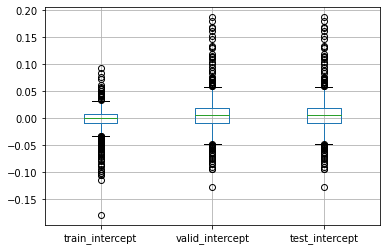

In [6]:
coef.drop(columns=factor_cols).boxplot()

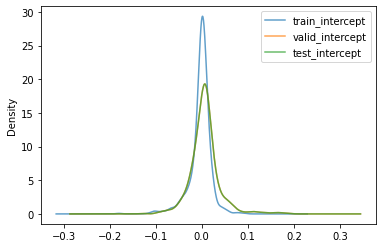

In [7]:
coef["train_intercept"].plot.kde(alpha=0.7)
coef["valid_intercept"].plot.kde(alpha=0.7)
coef["test_intercept"].plot.kde(alpha=0.7)
plt.legend()

In [8]:
# import facotr data
factor_data = pd.read_csv(processed_path["factor"])
factor_data[date_col] = pd.to_datetime(factor_data[date_col])
factor_data = factor_data.set_index(date_col)\
        .reindex(data.index.get_level_values(date_col).unique())\
        .sort_values(date_col)
factor_data.head()

,smb,hml,umd,rmrf
date,,,,
1998-01-31,-0.043322,-0.024549,0.106146,0.047304
1998-02-28,0.008035,-0.007590,-0.013334,0.053815
1998-03-31,0.022384,0.023637,0.002725,0.037095
1998-04-30,0.002902,-0.002640,-0.011305,-0.000947
1998-05-31,0.050016,-0.000236,0.014234,0.000646


In [9]:
# sharpe ratio
train_data = factor_data.iloc[:train_index, :]
valid_data = factor_data.iloc[train_index:valid_index, :]
test_data = factor_data.iloc[valid_index:, :]
train_sharpe = fama_sharpe(train_data)
valid_sharpe = fama_sharpe(valid_data)
test_sharpe = fama_sharpe(test_data)

train_sharpe, valid_sharpe, test_sharpe

(0.28587326744691566, 0.6222148237466848, 0.42316182284301057)

In [10]:
coef

,hml,rmrf,smb,umd,train_intercept,valid_intercept,test_intercept
3IN,0.276718,0.107114,-0.027427,-0.009705,0.002243,0.007851,0.007851
888,-0.268890,0.441525,0.045862,0.230667,0.001713,0.005537,0.005537
88E,5.940559,-5.522654,-7.530234,2.069211,-0.013257,0.030447,0.030447
AAIF,0.369862,-0.124749,-0.143021,-0.061102,0.008865,-0.003880,-0.003880
AAL,0.102185,0.047630,0.144582,-0.308291,0.011298,-0.013959,-0.013959
...,...,...,...,...,...,...,...
ZIOC,1.856091,-0.454311,1.755149,0.258530,-0.098083,0.161936,0.161936
ZOL,6.165694,-0.521288,-0.586116,1.347090,0.027960,-0.062722,-0.062722
ZOO,-1.255965,0.135807,0.522262,-0.621986,-0.014366,0.020553,0.020553
ZTF,0.226500,0.291467,0.352728,0.034285,-0.006456,0.021296,0.021296


In [11]:
# export results
coef.to_csv(f"{projectpath}/data/alpha/fama_{select}.csv")